<a href="https://colab.research.google.com/github/Murphy-Mary/MyProject/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data

souce :https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis
!unzip /content/twitter-entity-sentiment-analysis.zip && rm /content/twitter-entity-sentiment-analysis.zip

Mounted at /content/gdrive
  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 103MB/s]
Archive:  /content/twitter-entity-sentiment-analysis.zip
  inflating: twitter_training.csv    
  inflating: twitter_validation.csv  


In [ ]:
!pip install -q -U --pre pycaret
!python -m venv .env
!source /content/.env/bin
!pip install -U pip setuptools wheel
!pip install -U 'spacy[cuda-autodetect]'
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.1/480.1 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 KB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import spacy
from tqdm.auto import tqdm
import time
from sklearn.metrics import accuracy_score

In [ ]:
print(spacy.prefer_gpu())

True


## data

In [ ]:
df = pd.read_csv('/content/twitter_training.csv',header=None)

In [ ]:
df = df.rename(columns={0: "Id",1:"entity",2:"sentiment",3:"Tweet_content"})

In [ ]:
df

,Id,entity,sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             74682 non-null  int64 
 1   entity         74682 non-null  object
 2   sentiment      74682 non-null  object
 3   Tweet_content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
df.isna().sum()

Id                 0
entity             0
sentiment          0
Tweet_content    686
dtype: int64

In [ ]:
 df = df[df['Tweet_content'].notna()]

In [ ]:
df.isnull().sum()

Id               0
entity           0
sentiment        0
Tweet_content    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             73996 non-null  int64 
 1   entity         73996 non-null  object
 2   sentiment      73996 non-null  object
 3   Tweet_content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [ ]:
df.duplicated().sum()

2340

In [ ]:
df.drop_duplicates(inplace=True)

/usr/local/lib/python3.9/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.loc[df["sentiment"] == "Negative",'new_sent'] = 0
df.loc[df["sentiment"] == "Positive",'new_sent'] = 1
df.loc[df["sentiment"] == "Neutral",'new_sent'] = 2
df.loc[df["sentiment"] == "Irrelevant",'new_sent'] = 3
# df.loc[df["sentiment"] != "Neutral" and df["sentiment"] != "Positive" and df["sentiment"] != "Negative",'new_sent'] = 3

/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
df.isna().sum()

Id               0
entity           0
sentiment        0
Tweet_content    0
new_sent         0
dtype: int64

In [ ]:
df['new_sent'] = df['new_sent'].fillna(4)

<ipython-input-18-3fcc4110a6d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_sent'] = df['new_sent'].fillna(4)


In [ ]:
df

,Id,entity,sentiment,Tweet_content,new_sent
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,1.0
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,1.0
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,1.0
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,1.0
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,1.0
...,...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...,1.0
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...,1.0
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...,1.0
74680,9200,Nvidia,Positive,Just realized between the windows partition of...,1.0


#prepare

In [ ]:
# Load the English NLP model
spacy.prefer_gpu() # or spacy.require_gpu()
nlp = spacy.load('en_core_web_sm')

# Define stop words
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [ ]:
def preprocess_text(text):
    # Parse the text with Spacy
    doc = nlp(text)
    
    # Lemmatize the tokens and remove stop words
    lemmas = [token.lemma_.lower() for token in doc if not token.is_stop]
    
    # Join the lemmas back into a string and return it
    return " ".join(lemmas)

In [ ]:
%%time

tqdm.pandas()

df['Tweet_content'] = df['Tweet_content'].progress_apply(preprocess_text)

  0%|          | 0/71656 [00:00<?, ?it/s]

CPU times: user 24min 48s, sys: 10.9 s, total: 24min 59s
Wall time: 25min 42s


<timed exec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df

,Id,entity,sentiment,Tweet_content,new_sent
0,2401,Borderlands,Positive,"m get borderland murder ,",1.0
1,2401,Borderlands,Positive,"come border kill ,",1.0
2,2401,Borderlands,Positive,"m get borderland kill ,",1.0
3,2401,Borderlands,Positive,"m come borderland murder ,",1.0
4,2401,Borderlands,Positive,"m get borderland 2 murder ,",1.0
...,...,...,...,...,...
74677,9200,Nvidia,Positive,realize windows partition mac like 6 year nvid...,1.0
74678,9200,Nvidia,Positive,realize mac window partition 6 year nvidia dri...,1.0
74679,9200,Nvidia,Positive,realize window partition mac 6 year nvidia dri...,1.0
74680,9200,Nvidia,Positive,realize window partition mac like 6 year nvidi...,1.0


# Vectorizing the Text Data

In [ ]:
from sklearn.model_selection import train_test_split

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Tweet_content'], df['new_sent'], test_size=0.2, random_state=248362023)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# create bag-of-words features
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# ML


## Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB
# train a Naive Bayes classifier
clf = MultinomialNB()
clf

In [ ]:
clf.fit(X_train_vect, y_train)

## RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(n_estimators=10)
clf

In [ ]:
clf.fit(X_train_vect, y_train)

## neural_network 

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100, 2), random_state=746563)
#5,2
#10,2
#10,5

In [ ]:
 clf = clf.fit(X_train_vect, y_train)

# Predictions Section

In [ ]:
# evaluate the classifier on the test set
y_pred = clf.predict(X_test_vect)

In [ ]:
y_pred

array([2., 0., 3., ..., 0., 1., 0.])

In [ ]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.8253558470555401


# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[3654  181  436   26]
 [ 567 3136  270   36]
 [ 305   71 3127   89]
 [  74   87  361 1912]]


<AxesSubplot:>

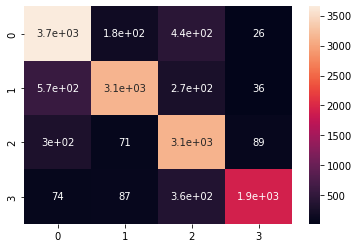

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True)

# Classification Report

In [ ]:
from sklearn.metrics import classification_report

# generate classification report
target_names = ['Negative', 'Positive','Neutral','Irrelevant']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.79      0.85      0.82      4297
    Positive       0.90      0.78      0.84      4009
     Neutral       0.75      0.87      0.80      3592
  Irrelevant       0.93      0.79      0.85      2434

    accuracy                           0.83     14332
   macro avg       0.84      0.82      0.83     14332
weighted avg       0.83      0.83      0.83     14332



NN
non - preproce


```
precision    recall  f1-score   support

    Negative       0.82      0.87      0.85      4297
    Positive       0.84      0.82      0.83      4009
     Neutral       0.84      0.75      0.79      3592
  Irrelevant       0.68      0.73      0.70      2434

    accuracy                           0.80     14332
   macro avg       0.79      0.79      0.79     14332
weighted avg       0.81      0.80      0.80     14332
```


```
precision    recall  f1-score   support

    Negative       0.82      0.79      0.81      4297
    Positive       0.65      0.73      0.69      4009
     Neutral       0.85      0.73      0.79      3592
  Irrelevant       0.47      0.49      0.48      2434

    accuracy                           0.71     14332
   macro avg       0.70      0.69      0.69     14332
weighted avg       0.72      0.71      0.71     14332
```


```
 precision    recall  f1-score   support

    Negative       0.81      0.88      0.85      4297
    Positive       0.84      0.84      0.84      4009
     Neutral       0.87      0.79      0.83      3592
  Irrelevant       0.82      0.80      0.81      2434

    accuracy                           0.83     14332
   macro avg       0.84      0.83      0.83     14332
weighted avg       0.84      0.83      0.83     14332
```





prepro


```
    precision    recall  f1-score   support

    Negative       0.30      1.00      0.46      4297
    Positive       0.00      0.00      0.00      4009
     Neutral       0.00      0.00      0.00      3592
  Irrelevant       0.00      0.00      0.00      2434

    accuracy                           0.30     14332
   macro avg       0.07      0.25      0.12     14332
weighted avg       0.09      0.30      0.14     14332
```



  
NO NLP
```
              precision    recall  f1-score   support

    Negative       0.70      0.86      0.77      4297
    Positive       0.73      0.81      0.76      4009
     Neutral       0.83      0.63      0.72      3592
       other       0.81      0.62      0.70      2434

    accuracy                           0.75     14332
    macro avg       0.77      0.73      0.74     14332
    weighted avg       0.76      0.75      0.74     14332
```


```
     precision    recall  f1-score   support

    Negative       0.92      0.95      0.93      4297
    Positive       0.91      0.93      0.92      4009
     Neutral       0.91      0.92      0.92      3592
       other       0.98      0.87      0.92      2434

    accuracy                           0.92     14332
   macro avg       0.93      0.92      0.92     14332
weighted avg       0.92      0.92      0.92     14332
```


NLP


```
 precision    recall  f1-score   support

    Negative       0.68      0.85      0.76      4297
    Positive       0.71      0.78      0.75      4009
     Neutral       0.81      0.64      0.71      3592
       other       0.81      0.61      0.70      2434

    accuracy                           0.74     14332
   macro avg       0.76      0.72      0.73     14332
weighted avg       0.75      0.74      0.73     14332
```
RDF 
n = 10

```
     precision    recall  f1-score   support

    Negative       0.88      0.91      0.89      4297
    Positive       0.82      0.92      0.86      4009
     Neutral       0.92      0.85      0.88      3592
       other       0.94      0.81      0.87      2434

    accuracy                           0.88     14332
   macro avg       0.89      0.87      0.88     14332
weighted avg       0.88      0.88      0.88     14332

```
n = 100


```
  precision    recall  f1-score   support

    Negative       0.91      0.92      0.92      4297
    Positive       0.85      0.93      0.89      4009
     Neutral       0.94      0.88      0.91      3592
       other       0.96      0.85      0.90      2434

    accuracy                           0.90     14332
   macro avg       0.91      0.90      0.90     14332
weighted avg       0.91      0.90      0.90     14332
```











# validate

In [ ]:
test = pd.read_csv('/content/twitter_validation.csv',header=None)

In [ ]:
test = test.rename(columns={0: "Id",1:"entity",2:"sentiment",3:"Tweet_content"})

In [ ]:
vtest=test['new_sent']

In [ ]:
pred = clf.predict(test)

In [ ]:
pred